
# Curvature


In [1]:
import principal_curvature as pc
import utils
import matplotlib.pyplot as plt

In [2]:
train_dataset = utils.import_train(10000)

In [3]:
train_dataset

ModelNet10(3991)

In [4]:
point_cloud = train_dataset[1]  # 1000 = chair

In [5]:
k = 5
knn_res = pc.k_nearest_neighbors(point_cloud.pos,k)
curve_res = pc.principal_curvature(point_cloud.pos,knn_res)

/Users/paulhosek/PycharmProjects/GeometricDL/principal_curvature.py:43: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/aten/src/ATen/native/Copy.cpp:250.)
  eigenvalues = torch.linalg.eigvals(cov).to(torch.float)


In [6]:
point_cloud_curve = point_cloud.pos[curve_res > curve_res.mean()]


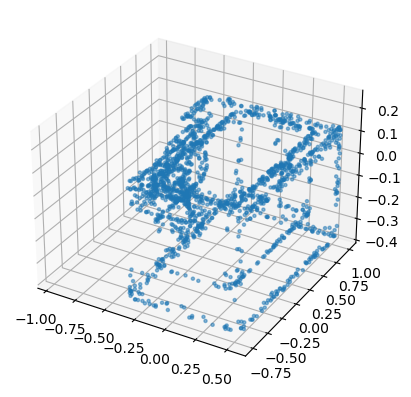

In [7]:
# %matplotlib qt

point_cloud_curve = point_cloud.pos[curve_res > curve_res.mean()]

x = point_cloud_curve[:, 0]
y = point_cloud_curve[:, 1]
z = point_cloud_curve[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='.', alpha=.5)

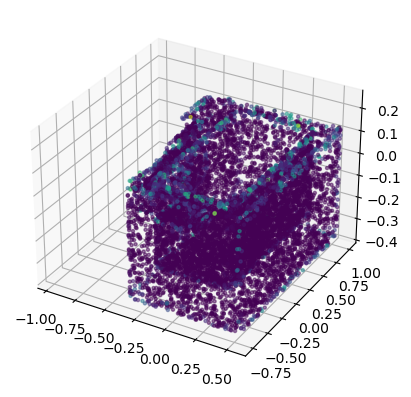

In [8]:
# %matplotlib qt

x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='.', alpha=.5, cmap="viridis",c=curve_res)

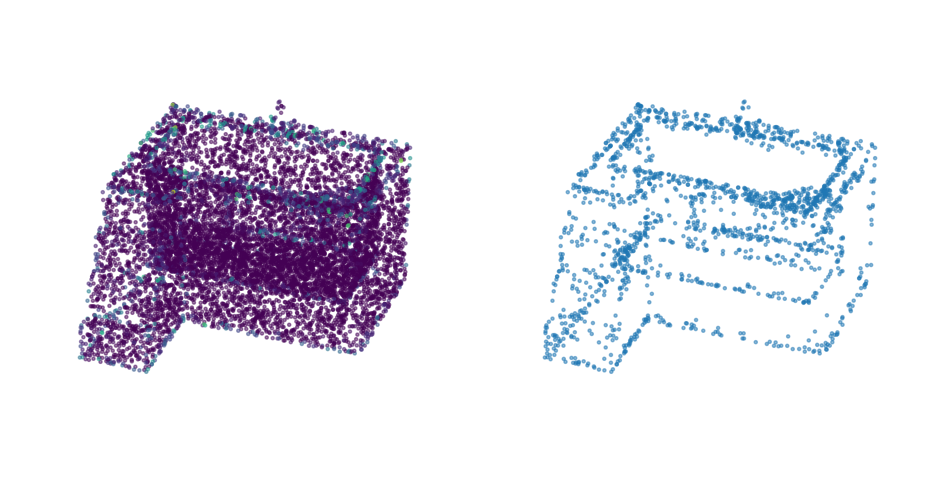

In [9]:
# %matplotlib qt


x = point_cloud.pos[:, 0]
y = point_cloud.pos[:, 1]
z = point_cloud.pos[:, 2]
# Create the first subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Plot the first scatter plot on the first subplot
axes[0].scatter(x, y, z, marker='.', alpha=0.5, c=curve_res)


# Select data for the second subplot
point_cloud_curve = point_cloud.pos[curve_res > curve_res.mean()]
x = point_cloud_curve[:, 0]
y = point_cloud_curve[:, 1]
z = point_cloud_curve[:, 2]
sc = axes[1].scatter(x, y, z, marker='.', alpha=0.5)
plt.axis('off')
axes[0].set_axis_off()
plt.subplots_adjust(wspace=0)
axes[0].view_init(elev=30, azim=200)
axes[1].view_init(elev=30, azim=200)
plt.savefig("../data/point_cloud_curve_illustration.png", bbox_inches="tight", dpi=300)


In [10]:
import scipy.stats as stats

In [11]:
def interpolate_with_distribution(distribution, z_score):
    # Calculate the left and right bounds based on the distribution
    # Calculate the bias based on the z-score
    # Perform linear interpolation


    left_bound = distribution.ppf(0.025)
    right_bound = distribution.ppf(0.975)
    bias = stats.norm.cdf(z_score)
    result = left_bound + (right_bound - left_bound) * bias
    return result

In [14]:
import principal_curvature
import torch
import numpy as np

In [13]:
def max_curve_sampler(cloud,desired_num_points, k):
    """
    Sample points with the highest curvature based on eigenvalues derived from their k-neighbourhood.

    :param cloud: Tensor of shape (N, C) representing the point cloud data.
    :param desired_num_points: Desired number of points to be sampled.
    :param k: Number of nearest neighbors to consider for curvature computation.
    :return: Tensor of shape (M,) containing the indices of the sampled points.
    """
    if cloud.size(0) < k:
        k = cloud.size(0)

    knn_res = principal_curvature.k_nearest_neighbors(cloud, k)
    curve_res = principal_curvature.principal_curvature(cloud, knn_res)
    curve_idx_reordered = torch.argsort(curve_res)[:desired_num_points]
    return curve_idx_reordered

want a bias parameter that we can move continuously from only taking the most curved points vs taking only fps

In [ ]:
def fps(points, n_samples):
    """
    points: [N, 3] array containing the whole point cloud
    n_samples: samples you want in the sampled point cloud typically << N
    """
    points = np.array(points)

    # Represent the points by their indices in points
    points_left = np.arange(len(points)) # [P]

    # Initialise an array for the sampled indices
    sample_inds = np.zeros(n_samples, dtype='int') # [S]

    # Initialise distances to inf
    dists = np.ones_like(points_left) * float('inf') # [P]

    # Select a point from points by its index, save it
    selected = 0
    sample_inds[0] = points_left[selected]

    # Delete selected
    points_left = np.delete(points_left, selected) # [P - 1]

    # Iteratively select points for a maximum of n_samples
    for i in range(1, n_samples):
        # Find the distance to the last added point in selected
        # and all the others
        last_added = sample_inds[i-1]

        dist_to_last_added_point = (
            (points[last_added] - points[points_left])**2).sum(-1) # [P - i]

        # If closer, updated distances
        dists[points_left] = np.minimum(dist_to_last_added_point,
                                        dists[points_left]) # [P - i]

        selected = np.argmax(dists[points_left])
        sample_inds[i] = points_left[selected]

        points_left = np.delete(points_left, selected)

    return points[sample_inds]